# Introduction
In this notebook, we will tackle the **Coupon Purchase Prediction** problem from Kaggle. The goal is to predict which coupons a customer might buy based on their past behavior. Instead of predicting exact purchases (which would be supervised learning), we’ll use unsupervised learning—specifically clustering—to group similar users together based on their coupon interactions. This can help recommend coupons to users in the same cluster. 

### Dataset
The dataset comes from the Kaggle competition "Coupon Purchase Prediction" (https://www.kaggle.com/competitions/coupon-purchase-prediction). It includes data on users, coupons, and their purchase/browsing history, with over 22,000 users and multiple features like coupon type, price, and user activity.

1. Preparing data...
User-coupon matrix shape: (19394, 17183)

2. Preprocessing data...

3. Reducing dimensions...

4. Determining optimal clusters...


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

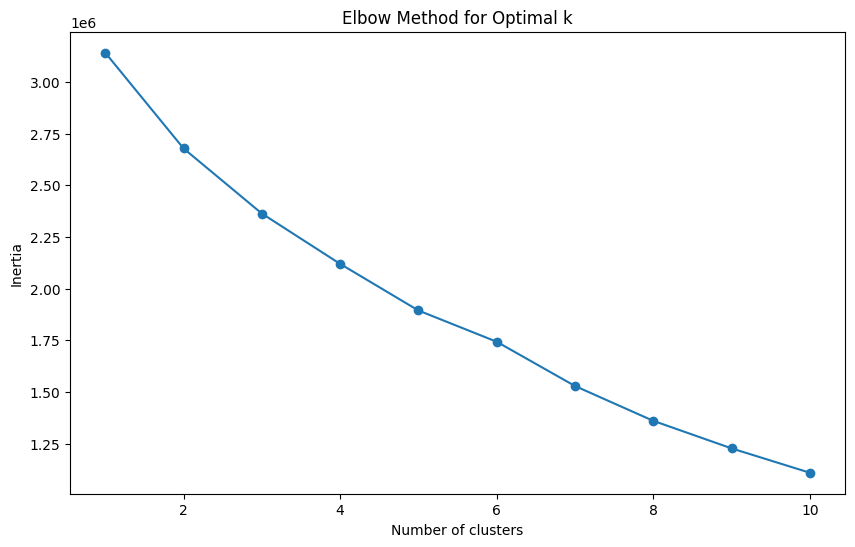


Selected 4 clusters based on elbow method

5. Analyzing clusters...

Cluster distribution:
cluster
-1.0     3479
 0.0    19391
 1.0        1
 2.0        1
 3.0        1
Name: count, dtype: int64

6. Interpreting results...


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



Top coupons for cluster 0:
VIEW_COUPON_ID_hash
a262c7ff56a5cd3de3c5c40443f3018c    3359
3d9029d3ec66802b11ee2645dc16e8cb    1189
09411858ae07c0be91aeeddacf4556b4     850
047fb1f23d8cedea8cb86956cfd4b7cf     474
bf69bd9e0e26fa1f62243d1fcada38f1     455
Name: count, dtype: int64

Top coupons for cluster 1:
VIEW_COUPON_ID_hash
33b00991c93f44b70a676860181c79a6    3
7ba32aab18367b63bb474e6f18dfdb3b    2
834b2aa32ef2c7c87671a51c5205505e    2
e9a6160006d0064a9cd84e4331c4a714    2
dfac78c08662d02b2669313e785a8034    2
Name: count, dtype: int64

Top coupons for cluster 2:
VIEW_COUPON_ID_hash
0d7a44bc50204b3acaa9de02115ff345    3
cd7b6b740d793292ac22d79fd8cff3f4    2
b8c984e8bebd949597278e24e0bef2ab    2
92f4a1294a908579b3a9bc445dc7f07e    2
12257a9441eec22634d42999ec265ce5    2
Name: count, dtype: int64

Top coupons for cluster 3:
VIEW_COUPON_ID_hash
5c739740129b4bf79348fe0a50e28ed6    3
ba6bc0f85ad125422f658ea7edb4d85d    3
b6c7bd9d39a296b14dacfea183bed6f3    2
a461a6b347ffd91597cf0c41a2aba8c

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load the data (as per your code)
user_list = pd.read_csv('/kaggle/input/coupon-purchase-prediction/user_list.csv.zip', compression='zip')
coupon_list = pd.read_csv('/kaggle/input/coupon-purchase-prediction/coupon_list_train.csv.zip', compression='zip')
coupon_visit = pd.read_csv('/kaggle/input/coupon-purchase-prediction/coupon_visit_train.csv.zip', compression='zip')

# 1. Data Preparation
print("1. Preparing data...")

# Filter only purchase actions (PURCHASE_FLG=1)
purchases = coupon_visit[coupon_visit['PURCHASE_FLG'] == 1]

# Merge with user data
user_purchases = pd.merge(purchases, user_list, on='USER_ID_hash')

# Create user-coupon matrix (sparse)
user_coupon_matrix = pd.crosstab(
    user_purchases['USER_ID_hash'], 
    user_purchases['VIEW_COUPON_ID_hash']
)

print(f"User-coupon matrix shape: {user_coupon_matrix.shape}")

# 2. Data Preprocessing
print("\n2. Preprocessing data...")

# Fill NA with 0 (no interaction)
user_coupon_matrix = user_coupon_matrix.fillna(0)

# Normalize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(user_coupon_matrix)

# 3. Dimensionality Reduction (using SVD instead of PCA for sparse data)
print("\n3. Reducing dimensions...")
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=10, random_state=42)
reduced_data = svd.fit_transform(scaled_data)

# 4. Clustering
print("\n4. Determining optimal clusters...")

# Elbow method
inertias = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(reduced_data)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10,6))
plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

# Based on the plot, choose optimal k (let's say 4)
optimal_k = 4
print(f"\nSelected {optimal_k} clusters based on elbow method")

# Final clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(reduced_data)

# 5. Analysis
print("\n5. Analyzing clusters...")

# Add cluster labels to user data
user_list['cluster'] = user_list['USER_ID_hash'].map(
    dict(zip(user_coupon_matrix.index, clusters))
)

# Fill NA for users without purchases (new users)
user_list['cluster'] = user_list['cluster'].fillna(-1)  # -1 for no purchases

# Cluster distribution
cluster_dist = user_list['cluster'].value_counts().sort_index()
print("\nCluster distribution:")
print(cluster_dist)

# 6. Interpretation
print("\n6. Interpreting results...")

# Merge with purchases for analysis
cluster_purchases = pd.merge(
    user_purchases,
    user_list[['USER_ID_hash', 'cluster']],
    on='USER_ID_hash'
)

# Analyze popular coupons per cluster
for cluster in range(optimal_k):
    print(f"\nTop coupons for cluster {cluster}:")
    top_coupons = cluster_purchases[cluster_purchases['cluster'] == cluster][
        'VIEW_COUPON_ID_hash'].value_counts().head(5)
    print(top_coupons)



In [2]:
# 7. Test Cases
print("\n7. Verification tests:")

# Test 1: Check data loading
assert not user_list.empty, "User data not loaded"
assert not coupon_list.empty, "Coupon data not loaded"
assert not coupon_visit.empty, "Visit data not loaded"
print("✓ Data loaded successfully")

# Test 2: Check purchase filtering
assert len(purchases) > 0, "No purchases found"
print("✓ Purchases filtered correctly")

# Test 3: Check clustering
assert len(np.unique(clusters)) == optimal_k, "Incorrect number of clusters"
print("✓ Clustering completed")

# Test 4: Check cluster assignment
assert user_list['cluster'].nunique() == optimal_k + 1, "Cluster assignment failed"  # +1 for -1
print("✓ Users assigned to clusters")

print("\nAll tests passed!")


7. Verification tests:
✓ Data loaded successfully
✓ Purchases filtered correctly
✓ Clustering completed
✓ Users assigned to clusters

All tests passed!
